In [1]:
import jaxley as jx
from jaxley.channels import Na, K, Leak
import matplotlib.pyplot as plt

# Tutorial 1: Build a cell and insert channels.

2024-09-26 17:16:24.193462: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Axes: >

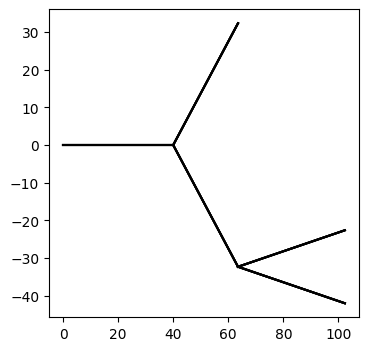

In [2]:
# Build the cell.
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1])

# Insert channels.
cell.insert(Leak())
cell.branch(0).insert(Na())
cell.branch(0).insert(K())

# Visualize the morphology.
cell.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


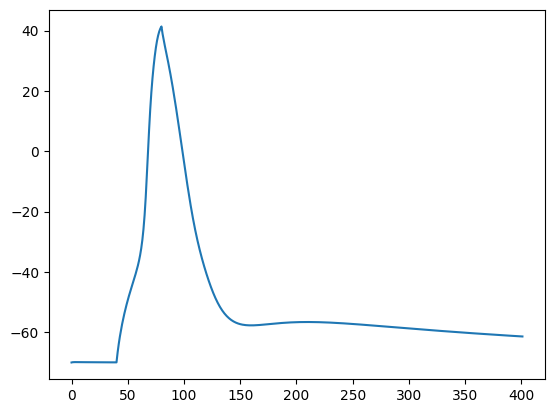

In [3]:
# Stimulate.
current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=0.025, t_max=10.0)
cell.branch(0).loc(0.0).stimulate(current)

# Record.
cell.branch(0).loc(0.0).record("v")

# Simulate and plot.
v = jx.integrate(cell)
plt.plot(v.T)

# Tutorial 2: Build a network and insert synapses.

In [4]:
import jaxley as jx
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect

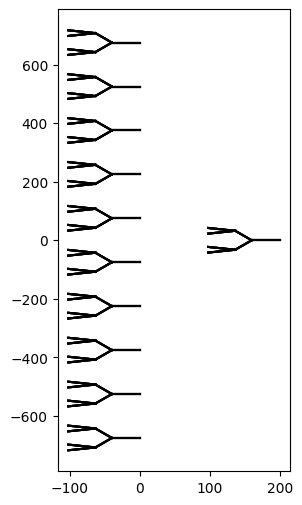

In [5]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])

num_cells = 11
net = jx.Network([cell for _ in range(num_cells)])

net.compute_xyz()
net.rotate(180)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

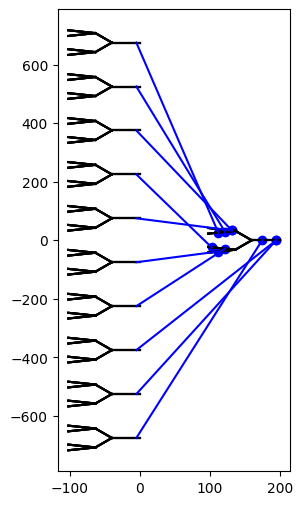

In [6]:
pre = net.cell(range(10))
post = net.cell(10)
fully_connect(pre, post, IonotropicSynapse())

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

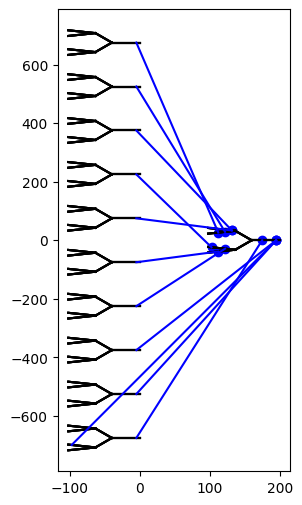

In [7]:
pre = net.cell(0).branch(5).loc(1.0)
post = net.cell(10).branch(0).loc(0.0)
connect(pre, post, IonotropicSynapse())

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

In [8]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

time_vec = jnp.arange(0.0, t_max + dt, dt)

In [9]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [10]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(10):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

net.delete_recordings()
net.cell(10).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


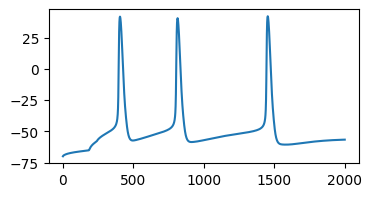

In [11]:
s = jx.integrate(net)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T)

# Tutorial 3: Set Parameters

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap

import jaxley as jx
from jaxley.channels import Na, K, Leak

In [13]:
dt = 0.025
t_max = 10.0

comp = jx.Compartment()
branch = jx.Branch(comp, nseg=2)
cell = jx.Cell(branch, parents=[-1, 0])

In [14]:
cell.set("radius", 0.1)
cell.branch(0).set("radius", 1.0)
cell.branch(0).comp(0).set("radius", 10.0)

cell.branch(0).set("axial_resistivity", 1000.0)
cell.set("length", 1.0)  # This will set every compartment in the cell to have length 1.0.

cell.nodes

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,1.0,10.0,1000.0,1.0,-70.0
1,1,0,0,1.0,1.0,1000.0,1.0,-70.0
2,2,1,0,1.0,0.1,5000.0,1.0,-70.0
3,3,1,0,1.0,0.1,5000.0,1.0,-70.0


In [15]:
cell.insert(Na())
cell.branch(1).comp(0).set("Na_gNa", 0.1)  # mS/cm^2
cell.nodes

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Na,Na_gNa,eNa,vt,Na_m,Na_h
0,0,0,0,1.0,10.0,1000.0,1.0,-70.0,True,0.05,50.0,-60.0,0.2,0.2
1,1,0,0,1.0,1.0,1000.0,1.0,-70.0,True,0.05,50.0,-60.0,0.2,0.2
2,2,1,0,1.0,0.1,5000.0,1.0,-70.0,True,0.10,50.0,-60.0,0.2,0.2
3,3,1,0,1.0,0.1,5000.0,1.0,-70.0,True,0.05,50.0,-60.0,0.2,0.2


In [16]:
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect

num_cells = 2
net = jx.Network([cell for _ in range(num_cells)])
fully_connect(net.cell(0), net.cell(1), IonotropicSynapse())

# Unlike for channels, you have to index into the synapse with `net.SynapseName`
net.IonotropicSynapse.set("IonotropicSynapse_gS", 0.1)  # nS

net.edges.transpose()

,0
pre_locs,0.25
post_locs,0.25
pre_branch_index,0
post_branch_index,0
pre_cell_index,0
post_cell_index,1
type,IonotropicSynapse
type_ind,0
global_pre_comp_index,0
global_post_comp_index,4


In [17]:
net.set("v", -72.0)  # mV
net.IonotropicSynapse.set("IonotropicSynapse_s", 0.1)  # nS
net.nodes

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Na,Na_gNa,eNa,vt,Na_m,Na_h
0,0,0,0,1.0,10.0,1000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2
1,1,0,0,1.0,1.0,1000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2
2,2,1,0,1.0,0.1,5000.0,1.0,-72.0,True,0.10,50.0,-60.0,0.2,0.2
3,3,1,0,1.0,0.1,5000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2
4,4,2,1,1.0,10.0,1000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2
5,5,2,1,1.0,1.0,1000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2
6,6,3,1,1.0,0.1,5000.0,1.0,-72.0,True,0.10,50.0,-60.0,0.2,0.2
7,7,3,1,1.0,0.1,5000.0,1.0,-72.0,True,0.05,50.0,-60.0,0.2,0.2


In [18]:
net.edges.transpose()

,0
pre_locs,0.25
post_locs,0.25
pre_branch_index,0
post_branch_index,0
pre_cell_index,0
post_cell_index,1
type,IonotropicSynapse
type_ind,0
global_pre_comp_index,0
global_post_comp_index,4


# Tutorial 5: Accelerate simulations with JIT and vmap

In [19]:
from jax import config
config.update("jax_platform_name", "gpu")
config.update("jax_enable_x64", True)  # Set to false to use `float32`.

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap

import jaxley as jx
from jaxley.channels import Na, K, Leak

In [20]:
dt = 0.025
t_max = 10.0

comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])

cell.insert(Na())
cell.insert(K())
cell.insert(Leak())

cell.delete_stimuli()
current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=dt, t_max=t_max)
cell.branch(0).loc(0.0).stimulate(current)

cell.delete_recordings()
cell.branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


In [21]:
def simulate(params):
    param_state = None
    param_state = cell.data_set("Na_gNa", params[0], param_state)
    param_state = cell.data_set("K_gK", params[1], param_state)
    return jx.integrate(cell, param_state=param_state)

In [22]:
# Define 5 sets of sodium and potassium conductances.
all_params = jnp.asarray(np.random.rand(5, 2))

voltages = jnp.asarray([simulate(params) for params in all_params])
print("voltages.shape", voltages.shape)

voltages.shape (5, 1, 402)


In [23]:
# def simulate(i_amp):
#     current = jx.step_current(1.0, 1.0, i_amp, 0.025, 10.0)

#     data_stimuli = None
#     data_stimuli = cell.branch(0).comp(0).data_stimulate(current, data_stimuli)
#     return jx.integrate(cell, data_stimuli=data_stimuli)

In [24]:
jitted_simulate = jit(simulate)

In [25]:
# First run, will be slow.
voltages = jitted_simulate(all_params[0])

In [26]:
# More runs, will be much faster.
print('size of all_params', all_params.shape)

voltages = jnp.asarray([jitted_simulate(params) for params in all_params])
print("voltages.shape", voltages.shape)

size of all_params (5, 2)
voltages.shape (5, 1, 402)


In [27]:
# Using vmap for parallelization.
vmapped_simulate = vmap(jitted_simulate)

In [28]:
voltages = vmapped_simulate(all_params)

In [29]:
jitted_vmapped_simulate = jit(vmap(simulate))

In [30]:
for batch in range(10):
    all_params = jnp.asarray(np.random.rand(5, 2))
    voltages_batch = jitted_vmapped_simulate(all_params)

# Tutorial 6: Building and using ion channel models

In [31]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import jaxley as jx

In [32]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])

# cell.insert(Na())
# cell.insert(K())
# cell.insert(Leak())

In [33]:
import jax.numpy as jnp
from jaxley.channels import Channel
from jaxley.solver_gate import solve_gate_exponential


def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)

class Potassium(Channel):
    """Potassium channel."""

    def __init__(self, name = None):
        super().__init__(name)
        self.channel_params = {"gK_new": 1e-4}
        self.channel_states = {"n_new": 0.0}
        self.current_name = "i_K"

    def update_states(self, states, dt, v, params):
        """Update state."""
        ns = states["n_new"]
        alpha = 0.01 * exp_update_alpha(-(v + 55), 10)
        beta = 0.125 * jnp.exp(-(v + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)
        return {"n_new": new_n}

    def compute_current(self, states, v, params):
        """Return current."""
        ns = states["n_new"]

        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * ns**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        return kd_conds * (v - e_kd)

    def init_state(self, states, v, params, delta_t):
        alpha = 0.01 * exp_update_alpha(-(v + 55), 10)
        beta = 0.125 * jnp.exp(-(v + 65) / 80)
        return {"n_new": alpha / (alpha + beta)}

In [34]:
cell.insert(Potassium())

In [35]:
cell.delete_stimuli()
current = jx.step_current(1.0, 1.0, 0.1, 0.025, 10.0)
cell.branch(0).comp(0).stimulate(current)

cell.delete_recordings()
cell.branch(0).comp(0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


In [36]:
s = jx.integrate(cell)

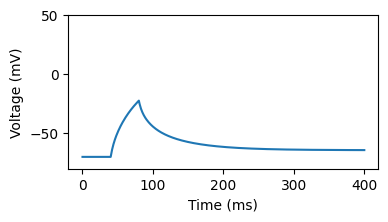

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

In [38]:
import jax.numpy as jnp
from jaxley.synapses.synapse import Synapse


class TestSynapse(Synapse):
    """
    Compute syanptic current and update syanpse state.
    """
    def __init__(self, name = None):
        super().__init__(name)
        self.synapse_params = {"gChol": 0.001, "eChol": 0.0}
        self.synapse_states = {"s_chol": 0.1}

    def update_states(self, states, delta_t, pre_voltage, post_voltage, params):
        """Return updated synapse state and current."""
        s_inf = 1.0 / (1.0 + jnp.exp((-35.0 - pre_voltage) / 10.0))
        exp_term = jnp.exp(-delta_t)
        new_s = states["s_chol"] * exp_term + s_inf * (1.0 - exp_term)
        return {"s_chol": new_s}

    def compute_current(self, states, pre_voltage, post_voltage, params):
        g_syn = params["gChol"] * states["s_chol"]
        return g_syn * (post_voltage - params["eChol"])

In [39]:
net = jx.Network([cell for _ in range(3)])

In [40]:
from jaxley.connect import connect

pre = net.cell(0).branch(0).loc(0.0)
post = net.cell(1).branch(0).loc(0.0)
connect(pre, post, TestSynapse())

In [41]:
net.cell(0).branch(0).loc(0.0).stimulate(jx.step_current(1.0, 2.0, 0.1, 0.025, 10.0))
for i in range(3):
    net.cell(i).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


In [42]:
s = jx.integrate(net)

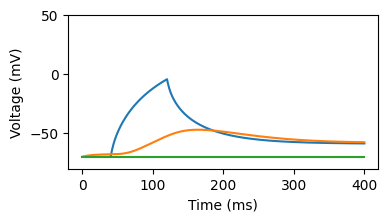

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

# Tutorial 7: Define Groups

In [44]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect

In [45]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=2)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1])
network = jx.Network([cell for _ in range(3)])

pre = network.cell([0, 1])
post = network.cell([2])
fully_connect(pre, post, IonotropicSynapse())

network.insert(Na())
network.insert(K())
network.insert(Leak())

In [46]:
for cell_ind in range(3):
    network.cell(cell_ind).branch(1).add_to_group("apical")
    network.cell(cell_ind).branch(3).add_to_group("apical")

In [47]:
network.apical.set("radius", 0.3)


In [48]:
network.nodes

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Na,Na_gNa,...,vt,Na_m,Na_h,K,K_gK,eK,K_n,Leak,Leak_gLeak,Leak_eLeak
0,0,0,0,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
1,1,0,0,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
2,2,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
3,3,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
4,4,2,0,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
5,5,2,0,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
6,6,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
7,7,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
8,8,4,1,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
9,9,4,1,10.0,1.0,5000.0,1.0,-70.0,True,0.05,...,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0


In [49]:
network.apical.view

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Na,Na_gNa,...,K_gK,eK,K_n,Leak,Leak_gLeak,Leak_eLeak,global_comp_index,global_branch_index,global_cell_index,controlled_by_param
2,2,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,2,1,0,0
3,3,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,3,1,0,0
6,6,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,6,3,0,0
7,7,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,7,3,0,0
10,10,5,1,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,10,5,1,0
11,11,5,1,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,11,5,1,0
14,14,7,1,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,14,7,1,0
15,15,7,1,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,15,7,1,0
18,18,9,2,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,18,9,2,0
19,19,9,2,10.0,0.3,5000.0,1.0,-70.0,True,0.05,...,0.005,-90.0,0.2,True,0.0001,-70.0,19,9,2,0


In [50]:
network.cell(0).add_to_group("fast_spiking")
network.cell(1).add_to_group("fast_spiking")

network.fast_spiking.set("Na_gNa", 0.4)

network.fast_spiking.view

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Na,Na_gNa,...,K_gK,eK,K_n,Leak,Leak_gLeak,Leak_eLeak,global_comp_index,global_branch_index,global_cell_index,controlled_by_param
0,0,0,0,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,0,0,0,0
1,1,0,0,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,1,0,0,0
2,2,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,2,1,0,0
3,3,1,0,10.0,0.3,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,3,1,0,0
4,4,2,0,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,4,2,0,0
5,5,2,0,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,5,2,0,0
6,6,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,6,3,0,0
7,7,3,0,10.0,0.3,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,7,3,0,0
8,8,4,1,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,8,4,1,0
9,9,4,1,10.0,1.0,5000.0,1.0,-70.0,True,0.4,...,0.005,-90.0,0.2,True,0.0001,-70.0,9,4,1,0


Note: If you are reading swc morphologigies, you can automatically assign groups with `jx.read_swc(file_name, assign_groups=True)`. After that, you can directly use `cell.soma`, `cell.apical`, `cell.basal`, or `cell.axon`.

In [51]:
network.fast_spiking.make_trainable("Na_gNa")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


In [52]:
network.get_parameters()

[{'Na_gNa': Array([0.4], dtype=float64)}]

In [53]:
network.cell([0,1]).make_trainable("axial_resistivity")

Number of newly added trainable parameters: 2. Total number of trainable parameters: 3


In [54]:
network.get_parameters()

[{'Na_gNa': Array([0.4], dtype=float64)},
 {'axial_resistivity': Array([5000., 5000.], dtype=float64)}]

# Tutorial 8: Training Models

In [55]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import TanhRateSynapse
from jaxley.connect import fully_connect

In [56]:
_ = np.random.seed(0)  # For synaptic locations.

comp = jx.Compartment()
branch = jx.Branch(comp, nseg=2)
cell = jx.Cell(branch, parents=[-1, 0, 0])
net = jx.Network([cell for _ in range(3)])

pre = net.cell([0, 1])
post = net.cell([2])
fully_connect(pre, post, TanhRateSynapse())

# Change some default values of the tanh synapse.
net.TanhRateSynapse.set("TanhRateSynapse_x_offset", -60.0)
net.TanhRateSynapse.set("TanhRateSynapse_gS", 1e-3)
net.TanhRateSynapse.set("TanhRateSynapse_slope", 0.1)

net.insert(Leak())

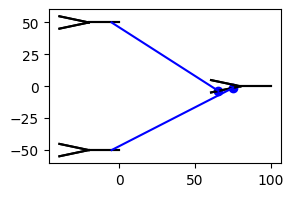

In [57]:
net.compute_xyz()
net.rotate(180)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = net.vis(ax=ax, detail="full", layers=[2, 1], layer_kwargs={"within_layer_offset": 100.0, "between_layer_offset": 100.0})

In [58]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()
net.cell(2).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


In [59]:
inputs = jnp.asarray(np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 1.0)

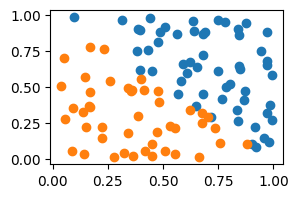

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [61]:
net.delete_trainables()
net.make_trainable("radius")
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")
# net.TanhRateSynapse.make_trainable("TanhRateSynapse_gS")
net.TanhRateSynapse("all").make_trainable("TanhRateSynapse_gS")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 18. Total number of trainable parameters: 19
Number of newly added trainable parameters: 2. Total number of trainable parameters: 21


In [62]:
params = net.get_parameters()
params


[{'radius': Array([1.], dtype=float64)},
 {'Leak_gLeak': Array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001], dtype=float64)},
 {'TanhRateSynapse_gS': Array([0.001, 0.001], dtype=float64)}]

In [63]:
s = jx.integrate(net, params=params, t_max=10.0)
print('s size', s.shape)

s size (3, 401)


In [64]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10, delta_t=0.025, t_max=10.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli)

batched_simulate = vmap(simulate, in_axes=(None, 0))

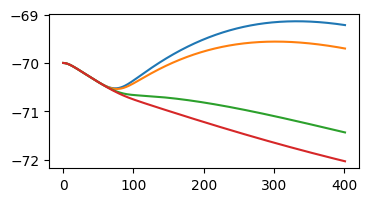

In [65]:
traces = batched_simulate(params, inputs[:4])
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 2, :].T)

In [66]:
def loss(params, inputs, labels):
    traces = batched_simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=1)  # Use the average over time of the output neuron (2) as prediction.
    prediction = (prediction + 72.0) / 5  # Such that the prediction is roughly in [0, 1].
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

In [67]:
jitted_grad = jit(value_and_grad(loss, argnums=0))

In [68]:
value, gradient = jitted_grad(params, inputs[:4], labels[:4])

In [69]:
transform = jx.ParamTransform(
    lowers={
        "Leak_gLeak": 1e-5,
        "radius": 0.1,
        "TanhRateSynapse_gS": 1e-5,
    },
    uppers={
        "Leak_gLeak": 1e-3,
        "radius": 5.0,
        "TanhRateSynapse_gS": 1e-2,
    }, 
)

In [70]:
def loss(opt_params, inputs, labels):
    transform.forward(opt_params)

    traces = batched_simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=1)  # Use the average over time of the output neuron (2) as prediction.
    prediction = (prediction + 72.0)  # Such that the prediction is around 0.
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

In [71]:
t_max = 5.0
dt = 0.025

levels = 2
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

To enable checkpointing, we have to modify the simulate function appropriately and use


`jx.integrate(..., checkpoint_inds=checkpoints)`

In [72]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10.0, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[2])  # Use the average over time of the output neuron (2) as prediction.
    return prediction + 72.0  # Such that the prediction is around 0.

batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)

    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

jitted_grad = jit(value_and_grad(loss, argnums=0))

In [75]:
import optax

In [76]:
opt_params = transform.inverse(params)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

In [77]:
# import tensorflow as tf
# from tensorflow.data import Dataset

In [78]:
# batch_size = 4

# tf.random.set_seed(1)
# dataloader = Dataset.from_tensor_slices((inputs, labels))
# dataloader = dataloader.shuffle(dataloader.cardinality()).batch(batch_size)

In [79]:
import jax
import jax.numpy as jnp

def create_batches(inputs, labels, batch_size, key, num_epochs=1):
    def data_generator():
        for _ in range(num_epochs):
            # Shuffle the data
            key_epoch = jax.random.fold_in(key, _)  # Create a new key for each epoch
            num_samples = len(inputs)
            perm = jax.random.permutation(key_epoch, num_samples)
            shuffled_inputs = inputs[perm]
            shuffled_labels = labels[perm]
            
            # Yield batches
            for i in range(0, num_samples, batch_size):
                batch_inputs = shuffled_inputs[i:i+batch_size]
                batch_labels = shuffled_labels[i:i+batch_size]
                
                # Pad the last batch if necessary
                if batch_inputs.shape[0] < batch_size:
                    pad_size = batch_size - batch_inputs.shape[0]
                    batch_inputs = jnp.pad(batch_inputs, ((0, pad_size), (0, 0)))
                    batch_labels = jnp.pad(batch_labels, (0, pad_size))
                
                yield batch_inputs, batch_labels

    return data_generator()

In [80]:
# Usage
batch_size = 4
num_epochs = 10
key = jax.random.PRNGKey(0)
dataloader = create_batches(inputs, labels, batch_size, key, num_epochs)

# Your training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_ind, (current_batch, label_batch) in enumerate(dataloader):
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val

    print(f"epoch {epoch}, loss {epoch_loss}")

final_params = transform.forward(opt_params)

epoch 0, loss 107.66483934316807
epoch 1, loss 0.0
epoch 2, loss 0.0
epoch 3, loss 0.0
epoch 4, loss 0.0
epoch 5, loss 0.0
epoch 6, loss 0.0
epoch 7, loss 0.0
epoch 8, loss 0.0
epoch 9, loss 0.0
